# Zestimate Log-Error Predictions

In this competition, Zillow is asking you to predict the log-error between their Zestimate and the actual sale price, given all the features of a home. The log error is defined as

logerror=log(Zestimate)−log(SalePrice)

and it is recorded in the transactions file train.csv. In this competition, you are going to predict the logerror for the months in Fall 2017. Since all the real estate transactions in the U.S. are publicly available, we will close the competition (no longer accepting submissions) before the evaluation period begins.

### Train/Test split

You are provided with a full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California) data in 2016.

The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.

The test data in the public leaderboard has the rest of the transactions between October 15 and December 31, 2016.

The rest of the test data, which is used for calculating the private leaderboard, is all the properties in October 15, 2017, to December 15, 2017. This period is called the "sales tracking period", during which we will not be taking any submissions.

You are asked to predict 6 time points for all properties: 
- October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

Not all the properties are sold in each time period. If a property was not sold in a certain time period, that particular row will be ignored when calculating your score.

If a property is sold multiple times within 31 days, we take the first reasonable value as the ground truth. By "reasonable", we mean if the data seems wrong, we will take the transaction that has a value that makes more sense.

### File descriptions
* **properties_2016.csv** - all the properties with their home features for 2016. Note: Some 2017 new properties don't have any data yet except for their parcelid's. Those data points should be populated when properties_2017.csv is available.
* **properties_2017.csv** - all the properties with their home features for 2017 (released on 10/2/2017)
* **train_2016.csv** - the training set with transactions from 1/1/2016 to 12/31/2016
* **train_2017.csv** - the training set with transactions from 1/1/2017 to 9/15/2017 (released on 10/2/2017)
* **sample_submission.csv** - a sample submission file in the correct format

### Data fields
Please refer to zillow_data_dictionary.xlsx

## Solution: 
Properties data has a lot of missing values. I would assume the majority of the logerror is coming from there. I investigated the data by cleaning and replacing the missing values with zero counts, and did a model fitting with that. The score is not appearing well however the feature importance plots were matching with the kaggle competation results. 

I would work on this data set more to make a better model fitting, however given than we have 4 hours to work this; I am going to return "StructureTaxValueDollarCnt" as the highest reason for the logarithmic estimation error. 

## 1. Data Cleaning

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import seaborn as sns
color = sns.color_palette()

%matplotlib inline
plt.style.use('ggplot')

pd.options.mode.chained_assignment = None  #??? What are these for
pd.options.display.max_columns = 999   #??? What are these for

In [2]:
prop_2016=pd.read_csv('properties_2016.csv')
prop_2016.head()

/Users/banuselintosun/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [3]:
prop_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
parcelid                        int64
airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottub

In [4]:
prop_2016.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,2.985217e+06,811519.000000,6061.000000,1628.000000,2.973755e+06,2.973767e+06,12629.000000,1.938488e+06,2.856305e+06,17096.0,...,2647.000000,2.925289e+06,682069.000000,2.930235e+06,2.942667e+06,2.973778e+06,2.917484e+06,2.953967e+06,56464.000000,2.910091e+06
mean,1.332586e+07,1.931166,7.202607,646.883292,2.209143e+00,3.088949e+00,3.725948,5.784787e+00,2.299263e+00,66.0,...,278.296562,1.964262e+03,1.401464,1.708836e+05,4.204790e+05,2.014999e+03,2.524780e+05,5.377607e+03,13.892409,6.048431e+13
std,7.909966e+06,3.148587,2.436290,538.793473,1.077754e+00,1.275859e+00,0.501700,1.805352e+00,1.000736e+00,0.0,...,369.731508,2.344132e+01,0.539076,4.020683e+05,7.263467e+05,3.683161e-02,4.450132e+05,9.183107e+03,2.581006,3.249035e+11
min,1.071172e+07,1.000000,2.000000,20.000000,0.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,66.0,...,10.000000,1.801000e+03,1.000000,1.000000e+00,1.000000e+00,2.000000e+03,1.000000e+00,1.340000e+00,0.000000,-1.000000e+00
25%,1.164371e+07,1.000000,7.000000,272.000000,2.000000e+00,2.000000e+00,3.000000,4.000000e+00,2.000000e+00,66.0,...,96.000000,1.950000e+03,1.000000,7.480000e+04,1.796750e+05,2.015000e+03,7.483600e+04,2.461070e+03,14.000000,6.037400e+13
50%,1.254509e+07,1.000000,7.000000,534.000000,2.000000e+00,3.000000e+00,4.000000,7.000000e+00,2.000000e+00,66.0,...,168.000000,1.963000e+03,1.000000,1.225900e+05,3.060860e+05,2.015000e+03,1.670420e+05,3.991780e+03,14.000000,6.037572e+13
75%,1.409712e+07,1.000000,7.000000,847.250000,3.000000e+00,4.000000e+00,4.000000,7.000000e+00,3.000000e+00,66.0,...,320.000000,1.981000e+03,2.000000,1.968890e+05,4.880000e+05,2.015000e+03,3.069180e+05,6.201005e+03,15.000000,6.059042e+13
max,1.696019e+08,13.000000,27.000000,8516.000000,2.000000e+01,2.000000e+01,5.000000,1.200000e+01,2.000000e+01,66.0,...,6141.000000,2.015000e+03,41.000000,2.514860e+08,2.827860e+08,2.016000e+03,9.024622e+07,3.458861e+06,99.000000,4.830301e+14


In [5]:
def recode_empty_cells(dataframe, column_name, val):
    dataframe[column_name] = dataframe[column_name].replace(r'\s+', np.nan, regex=True)
    dataframe[column_name] = dataframe[column_name].fillna(val)
    return dataframe[column_name].value_counts()

In [6]:
def check_for_empty_cells(dataframe, column_name):
    total = 0
    for row in dataframe[column_name].value_counts():
        total += row
    empty = len(dataframe) - total
    return "# of empty cells :", empty

In [7]:
for col in prop_2016.columns.values:
    print str(col), ':', check_for_empty_cells(prop_2016, str(col))[1]

parcelid : 0
airconditioningtypeid : 2173698
architecturalstyletypeid : 2979156
basementsqft : 2983589
bathroomcnt : 11462
bedroomcnt : 11450
buildingclasstypeid : 2972588
buildingqualitytypeid : 1046729
calculatedbathnbr : 128912
decktypeid : 2968121
finishedfloor1squarefeet : 2782500
calculatedfinishedsquarefeet : 55565
finishedsquarefeet12 : 276033
finishedsquarefeet13 : 2977545
finishedsquarefeet15 : 2794419
finishedsquarefeet50 : 2782500
finishedsquarefeet6 : 2963216
fips : 11437
fireplacecnt : 2672580
fullbathcnt : 128912
garagecarcnt : 2101950
garagetotalsqft : 2101950
hashottuborspa : 2916203
heatingorsystemtypeid : 1178816
latitude : 11437
longitude : 11437
lotsizesquarefeet : 276099
poolcnt : 2467683
poolsizesum : 2957257
pooltypeid10 : 2948278
pooltypeid2 : 2953142
pooltypeid7 : 2499758
propertycountylandusecode : 12277
propertylandusetypeid : 11437
propertyzoningdesc : 1006588
rawcensustractandblock : 11437
regionidcity : 62845
regionidcounty : 11437
regionidneighborhood : 

In [8]:
col_names_to_recode = []
for col in prop_2016.columns.values:
    if check_for_empty_cells(prop_2016, str(col))[1] != 0:
        col_names_to_recode.append(str(col))

In [9]:
not_to_recode = ['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']

In [10]:
for i, col in enumerate(col_names_to_recode):
    if col in not_to_recode:
        col_names_to_recode.pop(i)

In [11]:
for col in col_names_to_recode:
    if check_for_empty_cells(prop_2016, str(col))[1] != 0:
        recode_empty_cells(prop_2016, str(col), '0.0')

In [12]:
recode_empty_cells(prop_2016, 'taxdelinquencyflag', 'N')

N    2928755
Y      56462
Name: taxdelinquencyflag, dtype: int64

In [13]:
recode_empty_cells(prop_2016, 'fireplaceflag', 'False')

False    2980054
True        5163
Name: fireplaceflag, dtype: int64

In [14]:
recode_empty_cells(prop_2016, 'hashottuborspa', 'False')

False    2916203
True       69014
Name: hashottuborspa, dtype: int64

In [15]:
for col in prop_2016.columns.values:
    print str(col), ':', '\t', check_for_empty_cells(prop_2016, str(col))[1], '\t', prop_2016[col].dtype

parcelid : 	0 	int64
airconditioningtypeid : 	0 	object
architecturalstyletypeid : 	0 	object
basementsqft : 	0 	object
bathroomcnt : 	0 	object
bedroomcnt : 	0 	object
buildingclasstypeid : 	0 	object
buildingqualitytypeid : 	0 	object
calculatedbathnbr : 	0 	object
decktypeid : 	0 	object
finishedfloor1squarefeet : 	0 	object
calculatedfinishedsquarefeet : 	0 	object
finishedsquarefeet12 : 	0 	object
finishedsquarefeet13 : 	0 	object
finishedsquarefeet15 : 	0 	object
finishedsquarefeet50 : 	0 	object
finishedsquarefeet6 : 	0 	object
fips : 	0 	object
fireplacecnt : 	0 	object
fullbathcnt : 	0 	object
garagecarcnt : 	0 	object
garagetotalsqft : 	0 	object
hashottuborspa : 	0 	object
heatingorsystemtypeid : 	0 	object
latitude : 	0 	object
longitude : 	0 	object
lotsizesquarefeet : 	0 	object
poolcnt : 	0 	object
poolsizesum : 	0 	object
pooltypeid10 : 	0 	object
pooltypeid2 : 	0 	object
pooltypeid7 : 	0 	object
propertycountylandusecode : 	0 	object
propertylandusetypeid : 	0 	object


In [16]:
nbr_cols = ['basementsqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'finishedfloor1squarefeet', \
               'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', \
              'finishedsquarefeet6', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'latitude', \
               'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'roomcnt', 'threequarterbathnbr', 'unitcnt',\
              'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'structuretaxvaluedollarcnt', 'assessmentyear',\
           'taxamount', 'taxdelinquencyyear', 'finishedsquarefeet50', 'yearbuilt', 'taxvaluedollarcnt', \
           'landtaxvaluedollarcnt']

In [17]:
def change_dtype(df, column_list, datatype):
    for column_name in column_list:
        df[column_name] = df[column_name].astype(datatype)

In [18]:
def check_values(df, column_list):
    for column_name in column_list:
        print df[column_name].dtype

In [19]:
prop_2016['fireplaceflag'].loc[prop_2016['fireplaceflag'] == 'False'] = '0.0'
prop_2016['fireplaceflag'].value_counts()

/Users/banuselintosun/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


0.0     2980054
True       5163
Name: fireplaceflag, dtype: int64

In [20]:
prop_2016['fireplaceflag'].loc[prop_2016['fireplaceflag'] != '0.0'] = '1.0'
prop_2016['fireplaceflag'].value_counts()

0.0    2980054
1.0       5163
Name: fireplaceflag, dtype: int64

In [21]:
prop_2016['hashottuborspa'].loc[prop_2016['hashottuborspa'] != 'False'] = '1.0'
prop_2016['hashottuborspa'].loc[prop_2016['hashottuborspa'] == 'False'] = '0.0'
prop_2016['hashottuborspa'].value_counts()

0.0    2916203
1.0      69014
Name: hashottuborspa, dtype: int64

In [22]:
prop_2016['taxdelinquencyflag'].loc[prop_2016['taxdelinquencyflag'] != 'N'] = '1.0'
prop_2016['taxdelinquencyflag'].loc[prop_2016['taxdelinquencyflag'] == 'N'] = '0.0'
prop_2016['taxdelinquencyflag'].value_counts()

0.0    2928755
1.0      56462
Name: taxdelinquencyflag, dtype: int64

In [23]:
change_dtype(prop_2016, nbr_cols[:], 'float64')

In [24]:
# dtypes = ['int64', 'float64', 'datetime64[ns]', 'timedelta64[ns]', 'complex128', 'object', 'bool']

In [26]:
for col in prop_2016.columns.values:
    print str(col),'\t', prop_2016[col].dtype

parcelid 	int64
airconditioningtypeid 	object
architecturalstyletypeid 	object
basementsqft 	float64
bathroomcnt 	float64
bedroomcnt 	float64
buildingclasstypeid 	object
buildingqualitytypeid 	object
calculatedbathnbr 	float64
decktypeid 	object
finishedfloor1squarefeet 	float64
calculatedfinishedsquarefeet 	float64
finishedsquarefeet12 	float64
finishedsquarefeet13 	float64
finishedsquarefeet15 	float64
finishedsquarefeet50 	float64
finishedsquarefeet6 	float64
fips 	object
fireplacecnt 	float64
fullbathcnt 	float64
garagecarcnt 	float64
garagetotalsqft 	float64
hashottuborspa 	object
heatingorsystemtypeid 	object
latitude 	float64
longitude 	float64
lotsizesquarefeet 	float64
poolcnt 	float64
poolsizesum 	float64
pooltypeid10 	object
pooltypeid2 	object
pooltypeid7 	object
propertycountylandusecode 	object
propertylandusetypeid 	object
propertyzoningdesc 	object
rawcensustractandblock 	object
regionidcity 	object
regionidcounty 	object
regionidneighborhood 	object
regionidzip 	object

In [27]:
not_to_recode = ['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']
change_dtype(prop_2016, not_to_recode, 'float64')

In [28]:
for col in not_to_recode:
    print str(col),'\t', prop_2016[col].dtype

hashottuborspa 	float64
fireplaceflag 	float64
taxdelinquencyflag 	float64


In [29]:
for col in not_to_recode:
    print str(col),'\n', prop_2016[col].value_counts()

hashottuborspa 
0.0    2916203
1.0      69014
Name: hashottuborspa, dtype: int64
fireplaceflag 
0.0    2980054
1.0       5163
Name: fireplaceflag, dtype: int64
taxdelinquencyflag 
0.0    2928755
1.0      56462
Name: taxdelinquencyflag, dtype: int64


In [30]:
non_object_cols = []
for col in prop_2016.columns.values:
    if prop_2016[col].dtype != 'object':
        non_object_cols.append(str(col))

In [32]:
prop_2016.to_csv('./cleaned_prop_2016.csv')

In [33]:
small_df = prop_2016[non_object_cols]
small_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 37 columns):
parcelid                        int64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedbathnbr               float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                  float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
poolsizesum                     float64
roomcnt  

In [34]:
small_df.to_csv('./small_2016.csv')

In [48]:
logerror_2016 = pd.read_csv('train_2016_v2.csv')
logerror_2016.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [49]:
len(logerror_2016)

90275

In [50]:
logerror_2016['transactiondate'] =  pd.to_datetime(logerror_2016['transactiondate'], format='%Y-%m-%d')

In [51]:
print logerror_2016['transactiondate'].min()
print logerror_2016['transactiondate'].max()

2016-01-01 00:00:00
2016-12-30 00:00:00


In [52]:
logerror_2016['transactiondate'] = logerror_2016.transactiondate.apply(lambda x: x.strftime('%m-%d'))

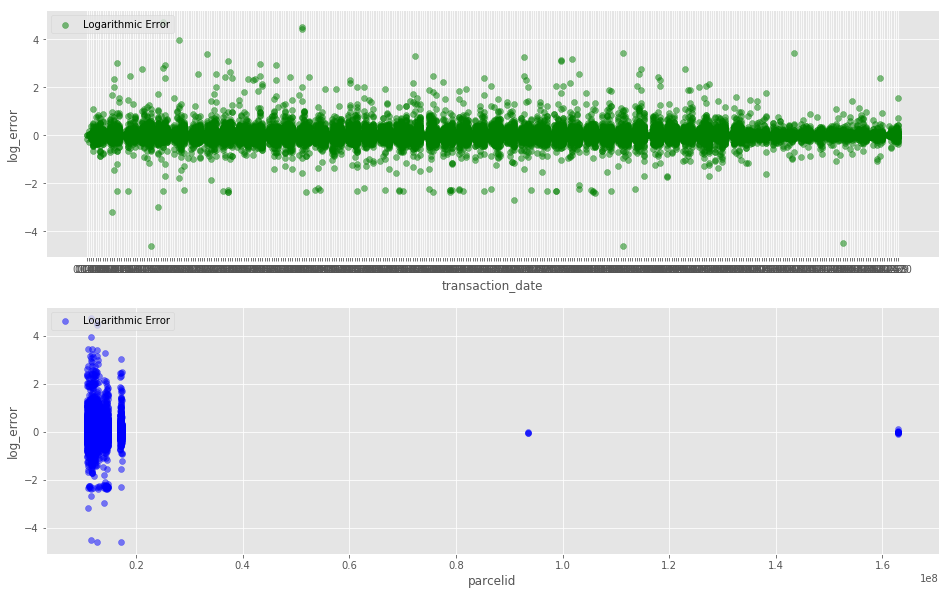

In [53]:
x = logerror_2016['transactiondate']
z = logerror_2016['parcelid']
y = logerror_2016['logerror']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,10))
plt.subplot(211)
plt.scatter(x, y, c="g", alpha=0.5, label="Logarithmic Error")
plt.xlabel("transaction_date")
plt.ylabel("log_error")
plt.legend(loc=2)
plt.subplot(212)
plt.scatter(z, y, c="b", alpha=0.5, label="Logarithmic Error")
plt.xlabel("parcelid")
plt.ylabel("log_error")
plt.legend(loc=2)
plt.show()

In [54]:
logerror_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Data columns (total 3 columns):
parcelid           90275 non-null int64
logerror           90275 non-null float64
transactiondate    90275 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ MB


In [55]:
for row in logerror_2016.transactiondate:
    print int(''.join(row.split('-'))[:-2])

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
6
1
1


1
8
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
6
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
8
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
9
1
1
1
1


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
12
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
6
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
9
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3

3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
9
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
5
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
10
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4

4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
7
4
4
4
4
4
4
4
4
4
6
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
8
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7


7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7


8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8


8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8


9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9


9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9


10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
1

12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
1

In [56]:
logerror_2016['transactiondate_month'] = logerror_2016.transactiondate.apply(lambda x: int(''.join(x.split('-'))[:-2]))

In [57]:
logerror_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Data columns (total 4 columns):
parcelid                 90275 non-null int64
logerror                 90275 non-null float64
transactiondate          90275 non-null object
transactiondate_month    90275 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ MB


In [59]:
logerror_2016['transactiondate_month'].value_counts()

6     10922
8     10476
5      9961
7      9947
9      9575
4      9311
3      8652
1      6556
2      6333
10     4977
11     1826
12     1739
Name: transactiondate_month, dtype: int64

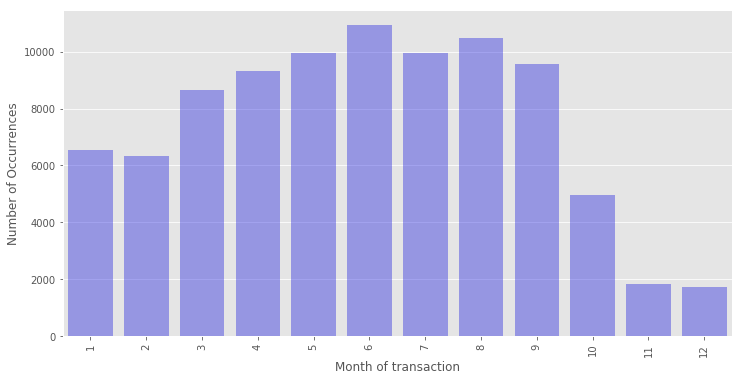

In [74]:
cnt_srs = logerror_2016['transactiondate_month'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.4, color='b')
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

In [75]:
(logerror_2016['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    90026
2      123
3        1
Name: parcelid, dtype: int64

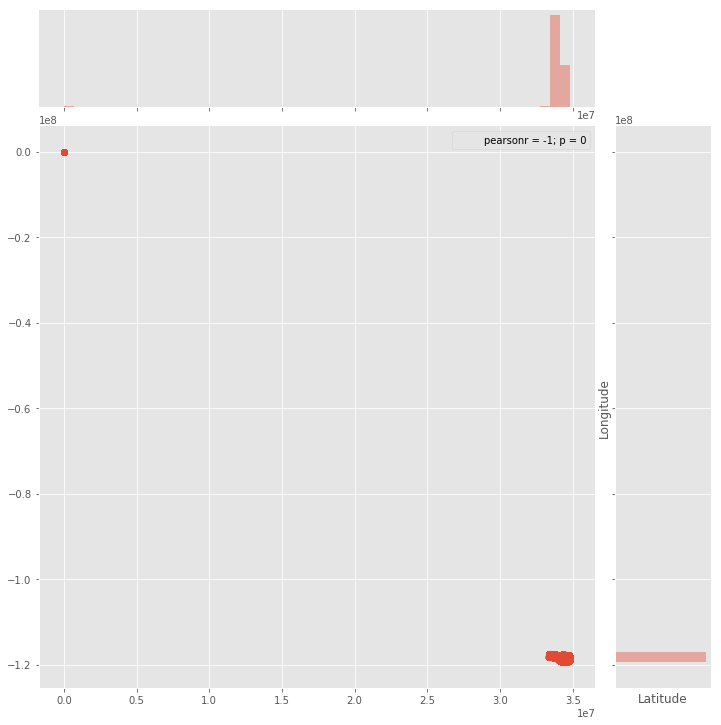

In [79]:
plt.figure(figsize=(12,12))
sns.jointplot(x=prop_2016.latitude.values, y=prop_2016.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

In [93]:
data2016 = pd.merge(prop_2016, logerror_2016, how='inner', on='parcelid', suffixes=('_prp', '_er'))
data2016.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate,transactiondate_month
0,17073783,0.0,0.0,0.0,2.5,3.0,0.0,0.0,2.5,0.0,548.0,1264.0,1264.0,0.0,0.0,548.0,0.0,6111,0.0,2.0,2.0,0.0,0.0,0.0,34303597.0,-119287236.0,1735.0,0.0,0.0,0.0,0.0,0.0,1128,265,0.0,6.111e+07,34543,2061,0.0,97081,5.0,0.0,1.0,0.0,0.0,128.0,0.0,1986.0,2.0,0.0,115087.0,191811.0,2015.0,76724.0,2015.06,0.0,0.0,6.111e+13,0.0953,01-27,1
1,17088994,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,777.0,777.0,777.0,0.0,0.0,777.0,0.0,6111,0.0,1.0,1.0,0.0,0.0,0.0,34272866.0,-119198911.0,0.0,0.0,0.0,0.0,0.0,0.0,1129,266,0.0,6.111e+07,34543,2061,0.0,97083,4.0,0.0,0.0,0.0,0.0,198.0,0.0,1990.0,1.0,0.0,143809.0,239679.0,2015.0,95870.0,2581.30,0.0,0.0,6.111e+13,0.0198,03-30,3
2,17100444,0.0,0.0,0.0,2.0,3.0,0.0,0.0,2.0,0.0,1101.0,1101.0,1101.0,0.0,0.0,1101.0,0.0,6111,0.0,2.0,2.0,441.0,0.0,0.0,34340801.0,-119079610.0,6569.0,0.0,0.0,0.0,0.0,0.0,1111,261,0.0,6.111e+07,26965,2061,0.0,97113,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1956.0,1.0,0.0,33619.0,47853.0,2015.0,14234.0,591.64,0.0,0.0,6.111e+13,0.0060,05-27,5
3,17102429,0.0,0.0,0.0,1.5,2.0,0.0,0.0,1.5,0.0,1554.0,1554.0,1554.0,0.0,0.0,1554.0,0.0,6111,1.0,1.0,2.0,460.0,0.0,0.0,34354313.0,-119076405.0,7400.0,0.0,0.0,0.0,0.0,0.0,1110,261,0.0,6.111e+07,26965,2061,0.0,97113,5.0,0.0,1.0,0.0,0.0,0.0,0.0,1965.0,1.0,0.0,45609.0,62914.0,2015.0,17305.0,682.78,0.0,0.0,6.111e+13,-0.0566,06-07,6
4,17109604,0.0,0.0,0.0,2.5,4.0,0.0,0.0,2.5,0.0,1305.0,2415.0,2415.0,0.0,0.0,1305.0,0.0,6111,1.0,2.0,2.0,665.0,0.0,0.0,34266578.0,-119165392.0,6326.0,0.0,0.0,0.0,0.0,0.0,1111,261,0.0,6.111e+07,34543,2061,0.0,97084,8.0,0.0,1.0,0.0,0.0,0.0,0.0,1984.0,2.0,0.0,277000.0,554000.0,2015.0,277000.0,5886.92,0.0,0.0,6.111e+13,0.0573,08-08,8


In [94]:
len(data2016)

90275

In [95]:
dtype_df = data2016.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,parcelid,int64
1,airconditioningtypeid,object
2,architecturalstyletypeid,object
3,basementsqft,float64
4,bathroomcnt,float64
5,bedroomcnt,float64
6,buildingclasstypeid,object
7,buildingqualitytypeid,object
8,calculatedbathnbr,float64
9,decktypeid,object


In [96]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,2
1,float64,37
2,object,22


In [97]:
x_cols = [col for col in data2016.columns if col not in ['logerror'] if data2016[col].dtype=='float64']

In [98]:
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(data2016[col].values, data2016.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

In [99]:
values

[0.009019339896495423,
 0.02788928655079262,
 0.02546709007097595,
 0.02811425529491637,
 0.012481519129440531,
 0.03901073917139132,
 0.03955702933055849,
 0.0036958500053616843,
 5.24417196951225e-05,
 0.012182934385434644,
 -0.009999629052303447,
 0.007746020347125671,
 0.027570917845063804,
 0.006139784833565565,
 0.008901197904458162,
 -0.005179421777079463,
 0.004915466425385793,
 -0.003432217232096932,
 0.005356500130123537,
 -0.008982692541820304,
 -0.0018985372986892056,
 0.005759796234842981,
 0.005490318840081132,
 -0.0033439598695227703,
 0.002496970680387551,
 -0.0008458372868550233,
 0.004637870611861785,
 0.004950364718477229,
 0.0011743690902797053,
 0.02314114149761829,
 0.0065255673973289305,
 nan,
 -0.0030360245244417695,
 -0.006670226921980962,
 0.01893558604587017,
 0.01810710355687974]

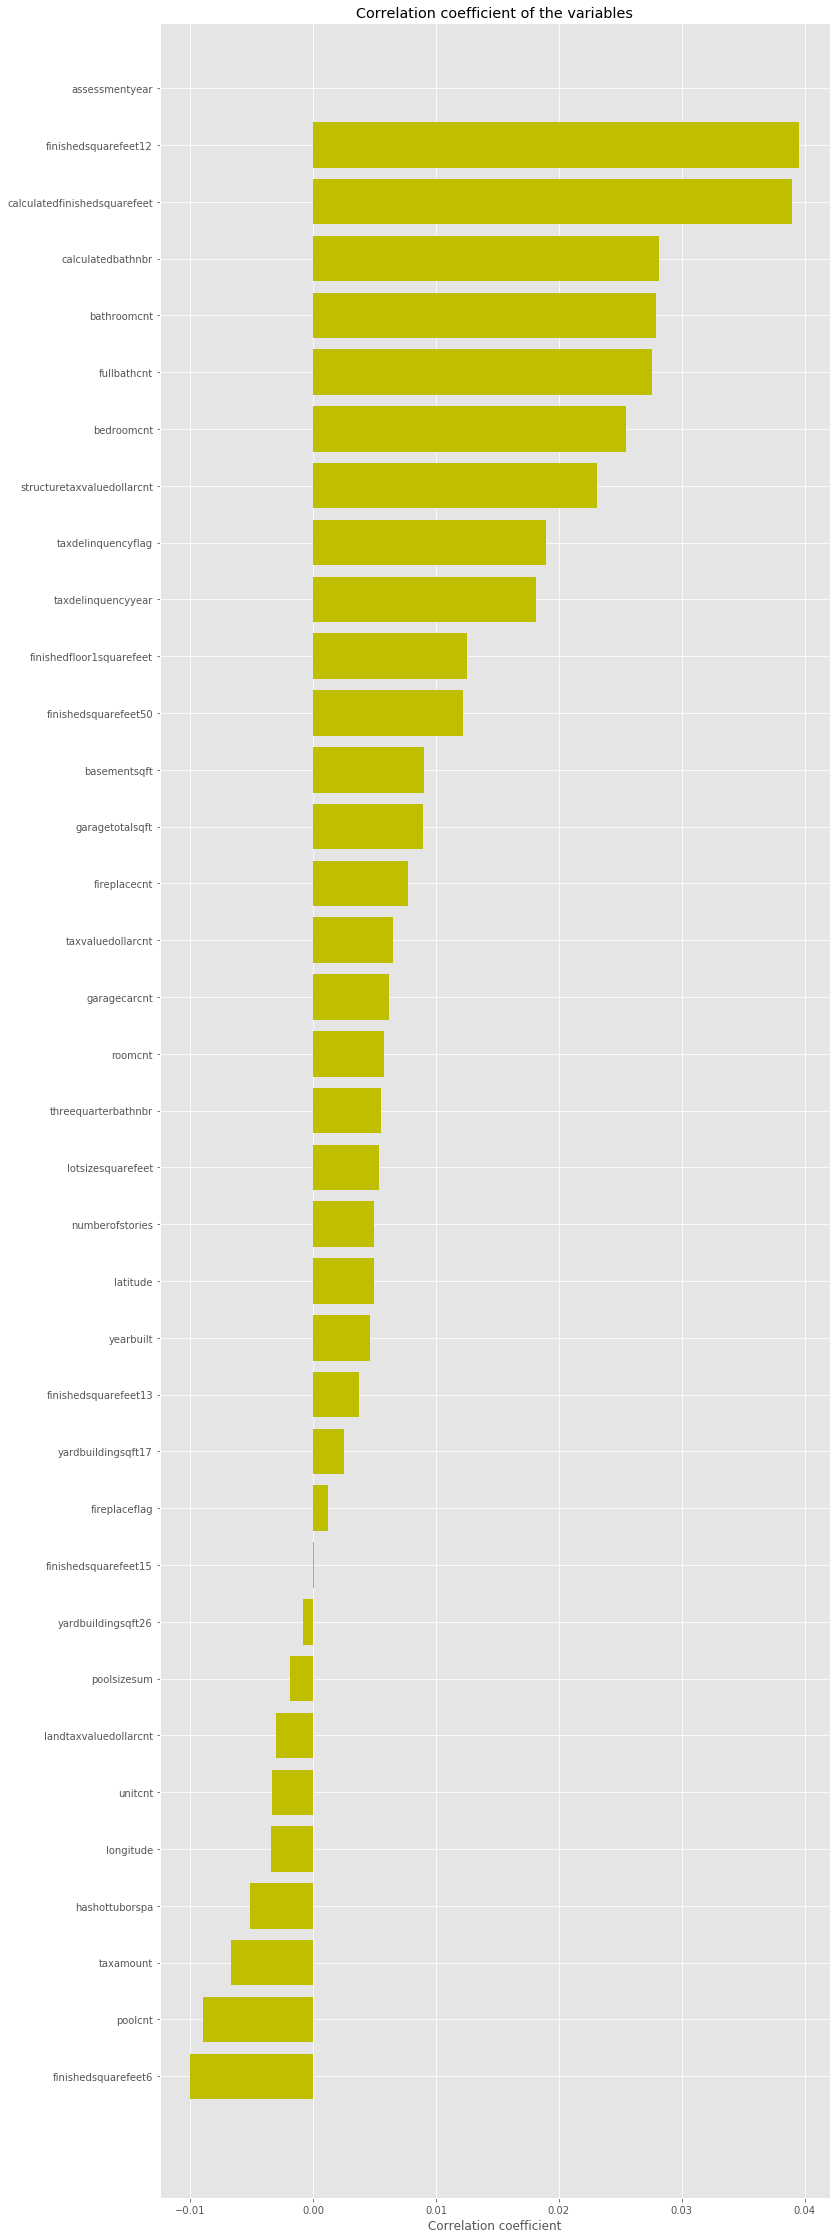

In [100]:
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

In [101]:
corr_zero_cols = ['assessmentyear']
for col in corr_zero_cols:
    print(col, len(data2016[col].unique()))

('assessmentyear', 1)


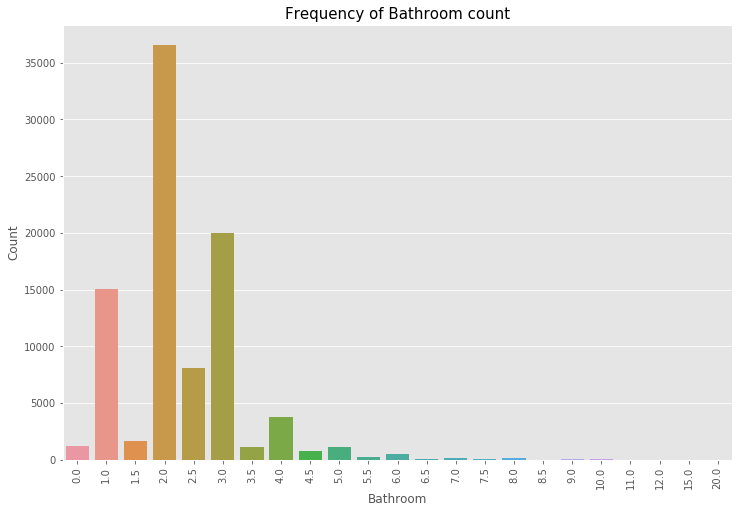

In [110]:
plt.figure(figsize=(12,8))
sns.countplot(x="bathroomcnt", data=data2016)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Bathroom', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bathroom count", fontsize=15)
plt.show()

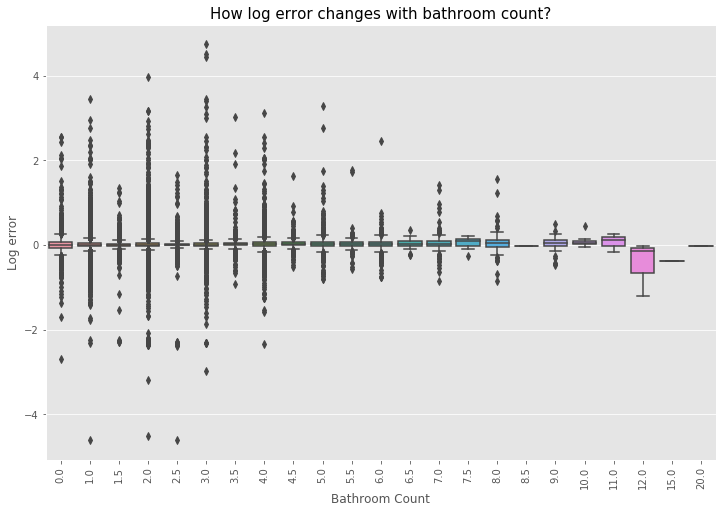

In [111]:
plt.figure(figsize=(12,8))
sns.boxplot(x="bathroomcnt", y="logerror", data=data2016)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

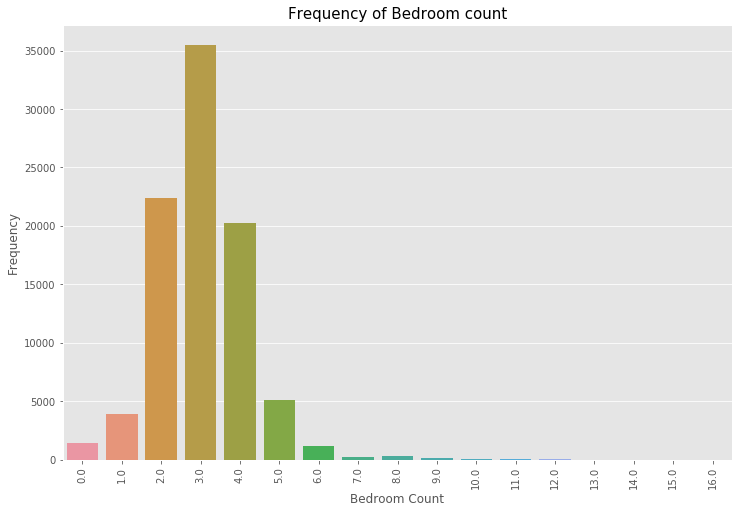

In [112]:
plt.figure(figsize=(12,8))
sns.countplot(x="bedroomcnt", data=data2016)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Bedroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Bedroom count", fontsize=15)
plt.show()

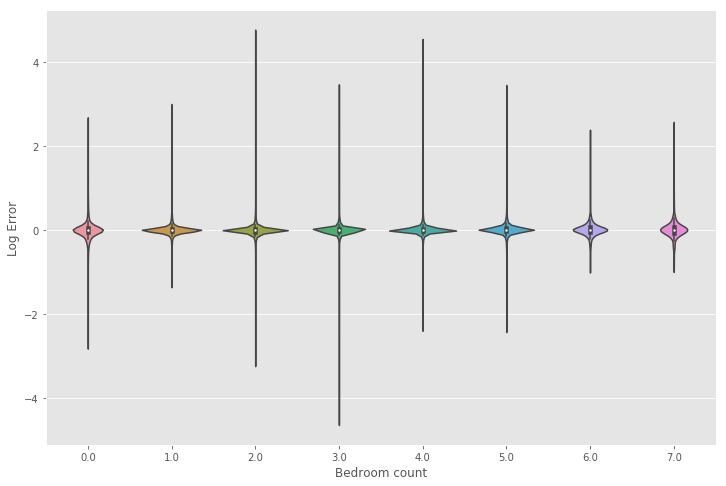

In [115]:
data2016['bedroomcnt'].loc[data2016['bedroomcnt']>7] = 7
plt.figure(figsize=(12,8))
sns.violinplot(x='bedroomcnt', y='logerror', data=data2016)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

In [120]:
y = small_df['logerror']
X = small_df.drop(['logerror', 'transactiondate'], axis=1)

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [122]:
FSM1 = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=0)
FSM1.fit(X_train, y_train)
y_predict1 = FSM1.predict(X_test).astype(int)
y_true = y_test.as_matrix()
FSM1.score(X_test, y_test)

-0.014352025801087187

In [124]:
importances = FSM1.feature_importances_

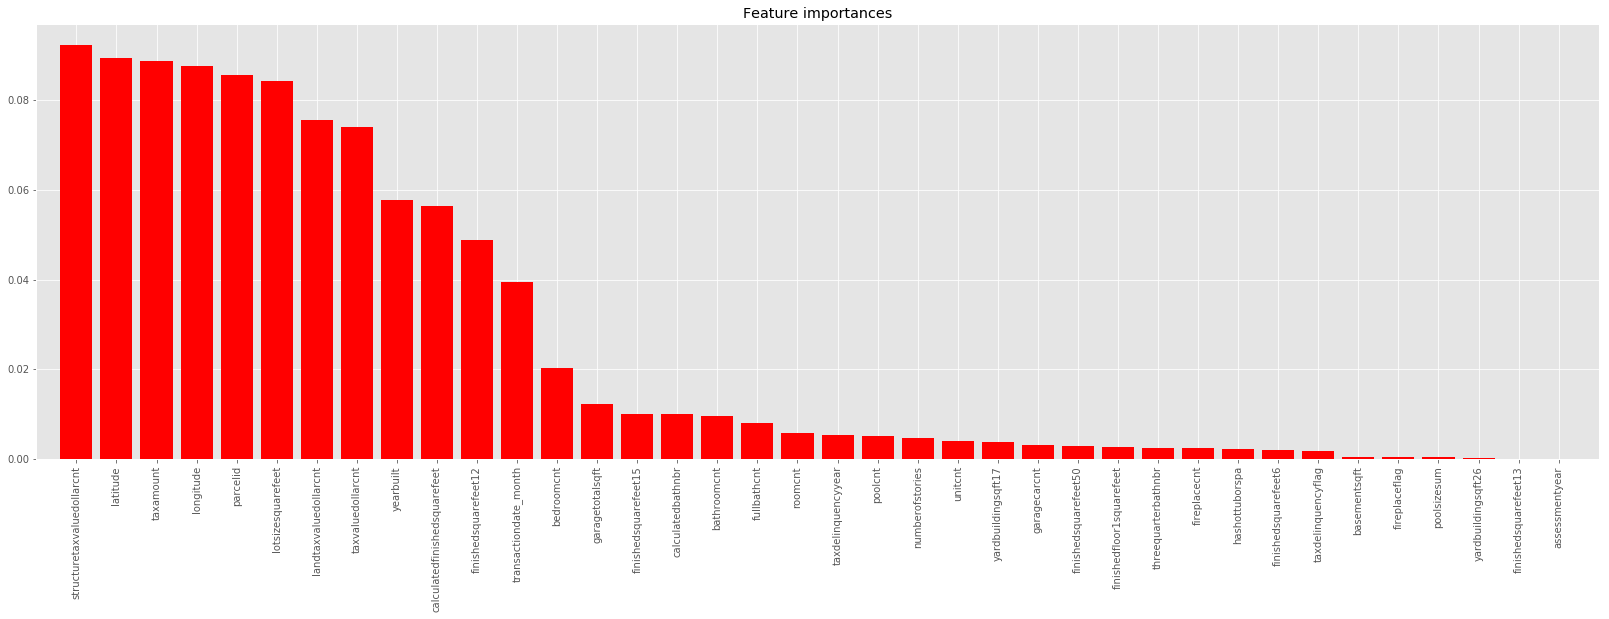

In [125]:
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(28,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), X.columns[indices],rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show();

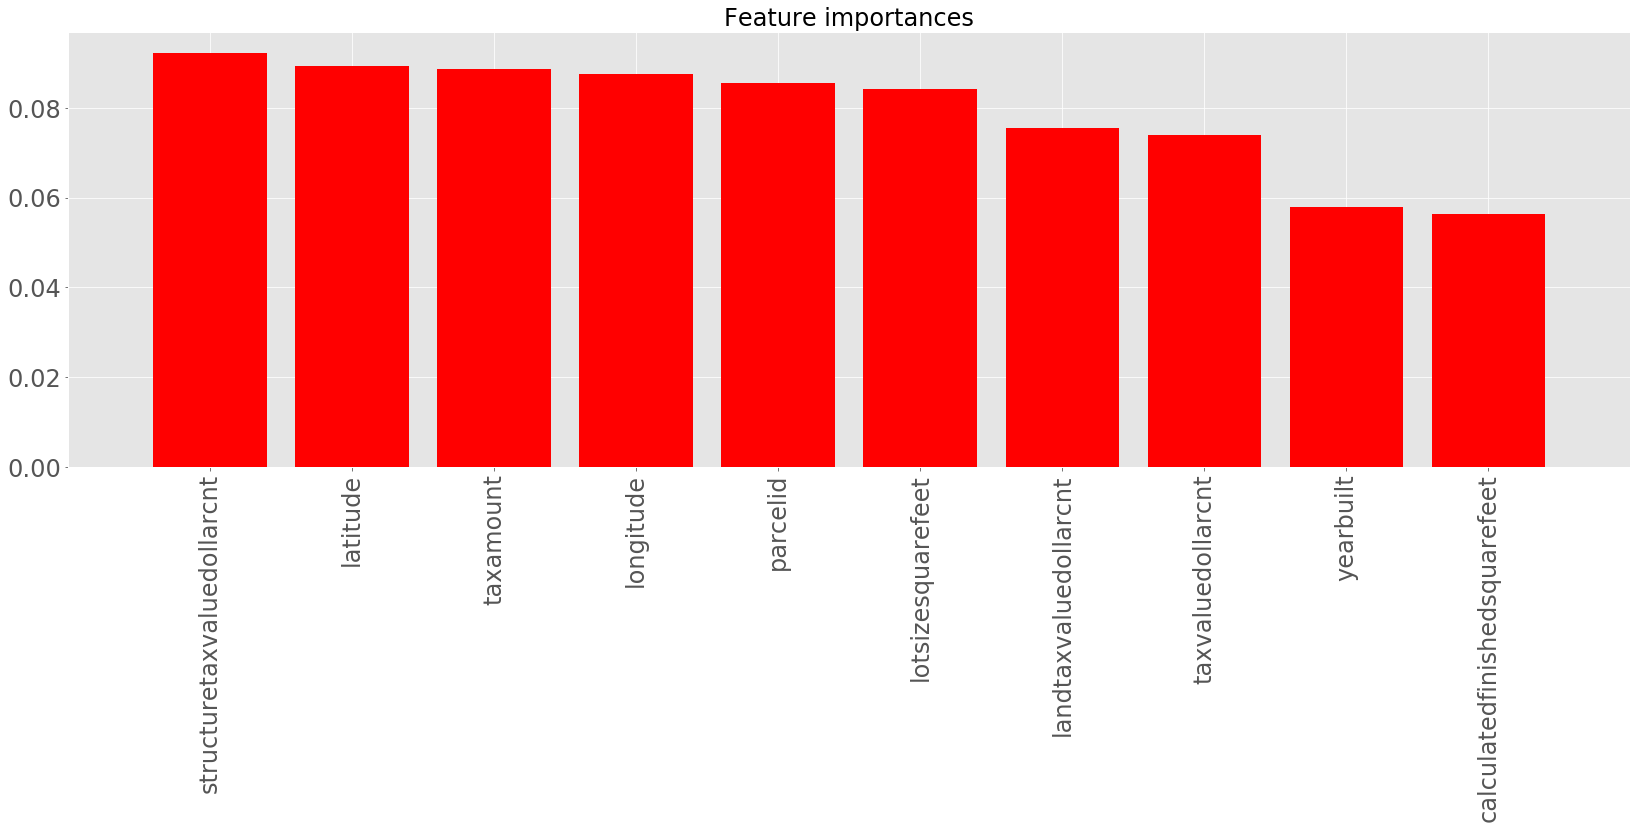

In [126]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(28,8))
plt.title("Feature importances", fontsize=24)
plt.bar(range(X.shape[1])[:10], importances[indices][:10],
       color="r", align="center")
plt.xticks(range(X.shape[1])[:10], X.columns[indices][:10],rotation='vertical', fontsize=24)
plt.yticks(fontsize=24)
plt.xlim([-1, 10])
#plt.gca().xaxis.label.set_fontsize(50)
plt.show();

## Solution:
Properties data has a lot of missing values. I would assume the majority of the logerror is coming from there. I investigated the data by cleaning and replacing the missing values with zero counts, and did a model fitting with that. The score is not appearing well however the feature importance plots were matching with the kaggle competation results.

I would work on this data set more to make a better model fitting, however given than we have 4 hours to work this; I am going to return "StructureTaxValueDollarCnt" as the highest reason for the logarithmic estimation error.

In [33]:
# def check_zero_as_an_entry(dataframe, column_name, val):
#     for row in dataframe[column_name]:
#         count = 0
#         if row == val:
#             count += 1
#     return count

In [34]:
# def change_NoVal_to_Val(dataframe, column_name, val):
#     for i, row in dataframe[column_name].iteritems():
#         if row == 'No_Val':
#             dataframe[column_name][i] = val
#     return dataframe[column_name].value_counts()

In [35]:
#check_zero_as_an_entry(prop_2016, 'basementsqft', '0.0')

In [36]:
# change_NoVal_to_Val(prop_2016, 'basementsqft', '0.0')

In [37]:
# for i, row in prop_2016['basementsqft'].iteritems():
#     if row != '0.0':
#         print i, row #= 0.0
#print prop_2016['basementsqft'].value_counts()

In [38]:
# def AFHistoricProperty_converter(df):
#     HP_dummies = pd.get_dummies(df.AFHistoricProperty, prefix='HP', drop_first=False)
#     df = pd.concat([df, HP_dummies], axis=1).drop('AFHistoricProperty', axis=1)
# return df